In [2]:
"""Imports"""
import keras
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.layers import Activation, Dense, Dropout, Input, LSTM
from keras.models import Sequential
from keras.utils import pad_sequences
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split


# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

2026-02-06 09:23:14.989030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
"""Load up the benzene data"""
path_to_file = Path(Path.cwd().parents[1], "Data", "Benzene.csv")
benzene = pd.read_csv(path_to_file)

benzene.head()

,Date,Time,C6H6(GT),PT08.S5(O3),Temperature (C),Relative Humidity,Absolute Humidity,Datetime
0,2004-03-10,18:00:00,0.18553,0.45482,0.33333,0.49937,0.28007,2004-03-10 18:00:00
1,2004-03-10,19:00:00,0.14623,0.32624,0.32688,0.48428,0.26428,2004-03-10 19:00:00
2,2004-03-10,20:00:00,0.13994,0.37055,0.29677,0.56352,0.27635,2004-03-10 20:00:00
3,2004-03-10,21:00:00,0.14308,0.42659,0.27742,0.63899,0.29419,2004-03-10 21:00:00
4,2004-03-10,22:00:00,0.10063,0.38619,0.28172,0.63396,0.29522,2004-03-10 22:00:00


# Linear Regression

In [3]:
"""Helper functions"""
def plot_lr_data(mu, prediction_horizon, number_of_samples, tp_pred, yp_pred, time_series, sensor_values, first=True):
	fig, ax = plt.subplots(figsize=(10,10))
	fig.suptitle(f"{['Last', 'First'][first]} 200 Sensor Output Prediction", fontsize=22, fontweight='bold')
	ax.set_title(f"mu = {mu}, ph = {prediction_horizon / 3600} hours")

	if first:
		ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
		ax.plot(time_series.iloc[0:200,0], sensor_values.iloc[0:200,0], label='Sensor Readings')
	else:
		ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
		ax.plot(time_series.iloc[number_of_samples-200:number_of_samples:,0],
		  sensor_values.iloc[number_of_samples-200:number_of_samples:,0], label='Sensor Readings')

	ax.set_xlabel("time (epoch)")
	ax.set_ylabel("normalized output")
	ax.legend()

	plt.show()

In [4]:
"""convert datetime to epoch/unix time and add as new column"""
benzene["Datetime"] = pd.to_datetime(benzene["Datetime"])
benzene["unix"] = benzene["Datetime"].apply(lambda x: x.timestamp())

benzene.head()

,Date,Time,C6H6(GT),PT08.S5(O3),Temperature (C),Relative Humidity,Absolute Humidity,Datetime,unix
0,2004-03-10,18:00:00,0.18553,0.45482,0.33333,0.49937,0.28007,2004-03-10 18:00:00,1078941600.00000
1,2004-03-10,19:00:00,0.14623,0.32624,0.32688,0.48428,0.26428,2004-03-10 19:00:00,1078945200.00000
2,2004-03-10,20:00:00,0.13994,0.37055,0.29677,0.56352,0.27635,2004-03-10 20:00:00,1078948800.00000
3,2004-03-10,21:00:00,0.14308,0.42659,0.27742,0.63899,0.29419,2004-03-10 21:00:00,1078952400.00000
4,2004-03-10,22:00:00,0.10063,0.38619,0.28172,0.63396,0.29522,2004-03-10 22:00:00,1078956000.00000


In [5]:
"""Setup data and train linear regression model to use as baseline"""
time_series = pd.DataFrame(benzene.unix)
sensor_values = pd.DataFrame(benzene.filter(["PT08.S5(O3)"]))

number_of_samples = len(time_series)
prediction_horizon = 24 * 3600
mu = 0.9

tp_pred = np.zeros(number_of_samples - 1)
yp_pred = np.zeros(number_of_samples - 1)

for i in range(2, number_of_samples + 1):
    ts_tmp = time_series[0:i]
    ys_tmp = sensor_values[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k] ** k
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    tp = time_series.iloc[i-1, 0] + prediction_horizon
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp.item()

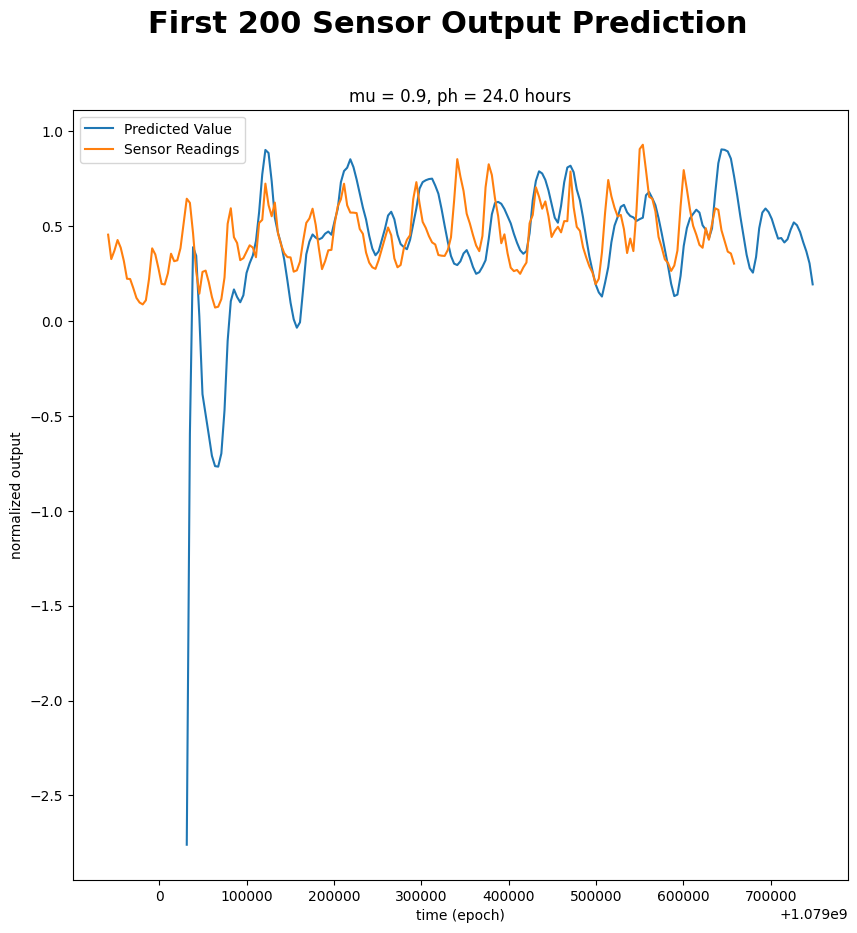

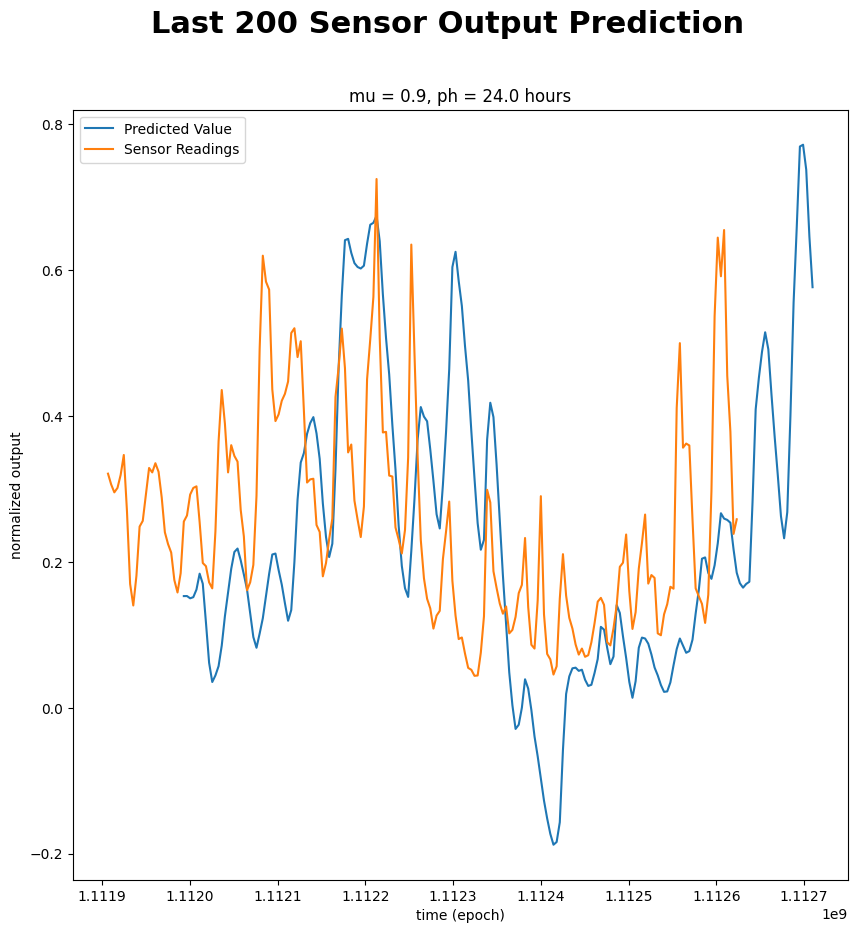

MSE is 0.018148589512320942


In [6]:
"""Visualize linear regression data"""
plot_lr_data(mu, prediction_horizon, number_of_samples, tp_pred, yp_pred, time_series, sensor_values, first=True)
plot_lr_data(mu, prediction_horizon, number_of_samples, tp_pred, yp_pred, time_series, sensor_values, first=False)
print("MSE is", mse(sensor_values["PT08.S5(O3)"][:-1], yp_pred))

- Predictions need to have a floor of 0 as a negative value is infeasible
- Need to convert from normalized back to ppm

In [7]:
"""Test different combos of variables"""
for column in ["Temperature (C)", "Relative Humidity", "Absolute Humidity"]:
	explanatories = pd.DataFrame({
	"epoch": benzene["unix"],
	"test": benzene[column]
	})

	tp2_pred = np.zeros(number_of_samples - 1)
	yp2_pred = np.zeros(number_of_samples - 1)

	for i in range(2, number_of_samples + 1):
		ts_tmp = explanatories[0:i]
		ys_tmp = sensor_values[0:i]
		ns = len(ys_tmp)

		weights = np.ones(ns) * mu
		for k in range(ns):
			weights[k] = weights[k] ** k
		weights = np.flip(weights, 0)

		lm_tmp = LinearRegression() 
		model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

		m_tmp = model_tmp.coef_
		q_tmp = model_tmp.intercept_

		time = explanatories.iloc[i-1, explanatories.columns.get_loc("epoch")] + prediction_horizon
		temp = explanatories.iloc[i-1, explanatories.columns.get_loc("test")]
		prediction = np.dot(m_tmp, np.array([time, temp])) + q_tmp

		tp2_pred[i-2] = time    
		yp2_pred[i-2] = prediction.item()

	print(f"MSE when using {column} is", mse(sensor_values["PT08.S5(O3)"][:-1], yp2_pred))

MSE when using Temperature (C) is 0.02216314269085993
MSE when using Relative Humidity is 0.02166899659905389
MSE when using Absolute Humidity is 0.02503436900628338


The MSE is worse than the base model for all attempts to use a secondary explanatory variable.

# LSTM

In [4]:
"""Helper functions"""
def plot_loss(history):
	fig_acc = plt.figure(figsize=(10, 10))
	plt.title("model loss/MSE")
	plt.ylabel("loss")
	plt.xlabel("epoch")

	plt.plot(history.history["loss"])
	plt.plot(history.history["val_loss"])

	plt.legend(["train", "test"], loc="upper left")
	plt.show()
	
	return fig_acc

def plot_predictions(predictions, truth):
	fig_verify = plt.figure(figsize=(10, 5))
	plt.title("O3 levels - Last 200 Points", fontsize=22, fontweight="bold")
	plt.ylabel("value")
	plt.xlabel("row")
	
	plt.plot(predictions[-200:], label = "Predicted Value")
	plt.plot(truth[-200:], label = "Actual Value")
	
	plt.legend()
	plt.show()

	return fig_verify

In [5]:
"""load in sensor data and split it for training and testing"""
sensor_data = benzene.filter(["PT08.S5(O3)"])

train, validate = train_test_split(sensor_data, train_size=0.8, random_state=73, shuffle=False)

training_data = train.reset_index(drop=True)
validation_data = validate.reset_index(drop=True)

assert len(training_data) + len(validation_data) == len(sensor_data)

print(f"Training data percentage: {round(len(training_data)/len(sensor_data), 2) * 100}%")

Training data percentage: 80.0%


In [6]:
"""We'll start out with a 7 day input sequence and a 24 hour predictive horizon"""
seq_length = 7 * 24
ph = 24
feat_cols = ["PT08.S5(O3)"]

seq_arrays = (
    np.array([training_data[i:i + seq_length] for i in range(len(training_data) - seq_length - ph)], dtype = object)
    .astype(np.float32)
)
seq_labs = (
    np.array([training_data.iloc[i + ph] for i in range(seq_length, len(training_data) - ph)], dtype = object)
    .astype(np.float32)
    .ravel()
)

assert(seq_arrays.shape == (len(training_data) - seq_length - ph, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(training_data) - seq_length - ph,))

seq_arrays.shape

(7293, 168, 1)

2026-02-06 09:23:58.117889: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 168, 5)         │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
14/14 - 3s - 181ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0395 - val_mse: 0.0395
Epoch 2/100
14/14 - 1s - 50ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 3/100
14/14 - 1s - 50ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 4/100
14/14 - 1s - 49ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 5/100
14/14 - 1s - 49ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 6/100
14/14 - 1s - 51ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 7/100
14/14 - 1s - 50ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 8/100
14/14 - 1s - 49ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 9/100
14/14 - 1s - 52ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 10/100
14/14 - 1s - 49ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0301 -

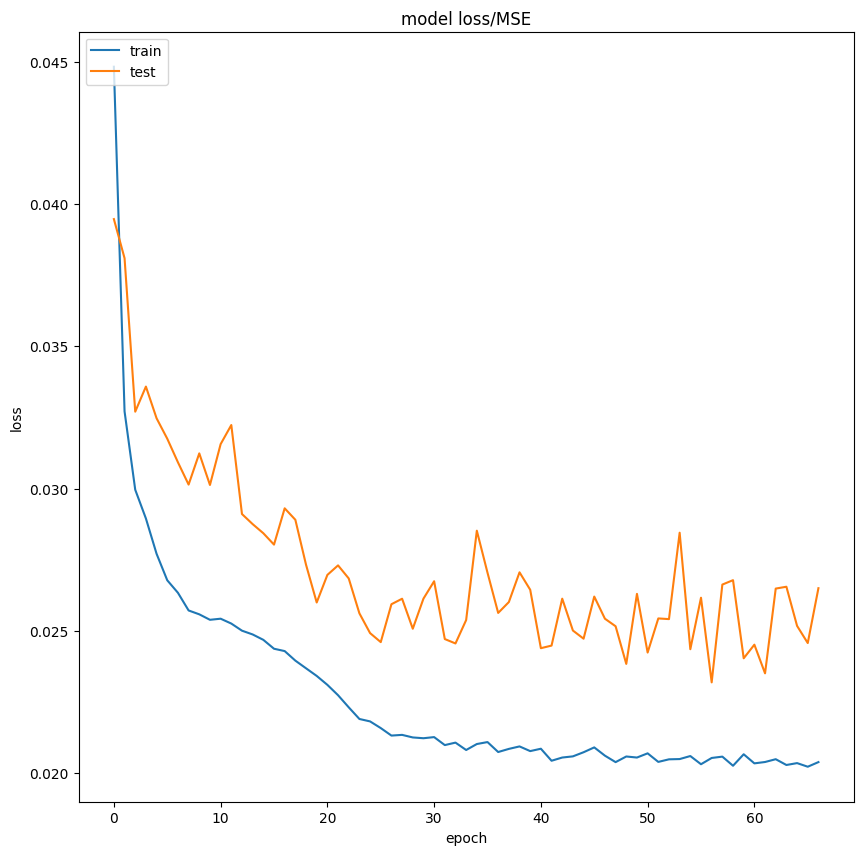

In [8]:
"""Layout Baseline architecture to use as comparision in future"""
model_path = "LSTM_baseline.keras"

nb_features = 1
nb_out = 1

model = Sequential()
model.add(Input(shape=(seq_length, nb_features)))
model.add(LSTM(units=5, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=3,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation(keras.activations.linear))

optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mse"])
print(model.summary())

history = model.fit(
    seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=0, mode="min")]
            #    keras.callbacks.ModelCheckpoint(model_path, monitor="val_loss", save_best_only=True, mode="min", verbose=0)]
    )
print(history.history.keys())

loss_figure = plot_loss(history)
# figure.savefig(model_path.split(".")[0]+".png")

In [9]:
"""Create our validation sequence with a minimum number of records left padded with zeros"""
MIN_COUNT = 2

val_arrays = (
    np.array(pad_sequences([
    	validation_data[max(0, i): i + seq_length].values
    	for i in range(MIN_COUNT - seq_length, len(validation_data) - seq_length - ph)
		], dtype="float32"))
    .astype(np.float32)
)
val_labs = (
    np.array(
        [validation_data.iloc[i + ph] for i in range(MIN_COUNT, len(validation_data) - ph)])
    .astype(np.float32)
    .ravel()
)

assert(val_arrays.shape == (len(validation_data) - ph - MIN_COUNT, seq_length, len(feat_cols)))
assert(val_labs.shape == (len(validation_data) - ph - MIN_COUNT,))

val_arrays.shape

(1846, 168, 1)

58/58 - 0s - 7ms/step - loss: 0.0281 - mse: 0.0281
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


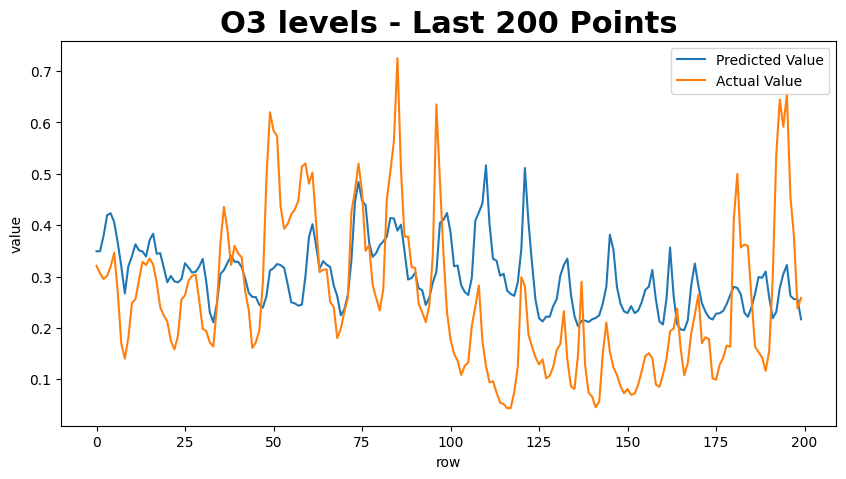


MSE: 0.028092917054891586


In [10]:
"""Score our baseline model and visualize it's predictions"""
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
predictions = model.predict(val_arrays)

predictions_figure = plot_predictions(predictions, val_labs)
print("\nMSE: {}".format(scores_test[1]))

Looks like there is quite some room for improvement

In [ ]:
"""Tune the hyperparameters to see what we can get"""
def build_model(hp, lookback_period):
	use_second_lstm_layer = hp.Boolean("use_second_lstm", default=False)
	first_layer_units = hp.Int("units_1", min_value=5, max_value=12, step=1)
	second_layer_units = hp.Int("units_2", min_value=3, max_value=7, step=1)
	dropout = hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1)
	lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
	activation = hp.Choice("activation_function", ["linear", "sigmoid"])

	model = Sequential()
	model.add(Input(shape=(lookback_period, nb_features)))
	if use_second_lstm_layer:
		model.add(LSTM(first_layer_units, return_sequences=True))
		model.add(LSTM(second_layer_units, return_sequences=False))
	else:
		model.add(LSTM(first_layer_units, return_sequences=False))
	model.add(Dropout(dropout))
	model.add(Dense(nb_out, activation=activation))

	optimizer = keras.optimizers.Adam(learning_rate=lr)

	model.compile(
		optimizer=optimizer,
		loss="mse",
		metrics=["mse"]
	)

	return model

best = {}
for i in range(7, 15):
	seq_length = i * 24
	ph = 24
	feat_cols = ["PT08.S5(O3)"]

	seq_arrays = (
		np.array([training_data[i:i + seq_length] for i in range(len(training_data) - seq_length - ph)], dtype = object)
		.astype(np.float32)
	)
	seq_labs = (
		np.array([training_data.iloc[i + ph] for i in range(seq_length, len(training_data) - ph)], dtype = object)
		.astype(np.float32)
		.ravel()
	)

	assert(seq_arrays.shape == (len(training_data) - seq_length - ph, seq_length, len(feat_cols)))
	assert(seq_labs.shape == (len(training_data) - seq_length - ph,))

	tuner = keras_tuner.RandomSearch(
		lambda hp: build_model(hp, seq_length),
		objective="val_loss",
		max_trials=30,
		executions_per_trial=2,
		directory=f"looking_back_{seq_length}",
		project_name="tuning"
	)

	tuner.search(
		seq_arrays, seq_labs,
		validation_data=(val_arrays, val_labs),
		epochs=10,
		batch_size=32,
		callbacks=[
			keras.callbacks.EarlyStopping(
				monitor="val_loss",
				patience=5,
				restore_best_weights=True
			)
		]
	)

	best_hp = tuner.get_best_hyperparameters()[0]
	best_trial = tuner.oracle.get_best_trials()[0]
	best_score = best_trial.score

	best[seq_length] = (best_hp, best_score)

lookback, (hp, score) = min(best.items(), key=lambda item: item[1][1])
print(lookback)
print(hp.values)
print(score)

Took too long on local machine... Had to move it up to colab.

```
240
{'use_second_lstm': True,
 'units_1': 11,
 'units_2': 7,
 'dropout': 0.1,
 'learning_rate': 0.0005,
 'activation_function': 'sigmoid'}
 .029

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 240, 11)        │           572 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 7)              │           532 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,112 (4.34 KB)

 Trainable params: 1,112 (4.34 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
14/14 - 3s - 201ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2/100
14/14 - 1s - 87ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 3/100
14/14 - 1s - 79ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 4/100
14/14 - 1s - 84ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 5/100
14/14 - 1s - 79ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 6/100
14/14 - 1s - 83ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 7/100
14/14 - 1s - 81ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 8/100
14/14 - 1s - 83ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 9/100
14/14 - 1s - 84ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 10/100
14/14 - 1s - 80ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0275 -

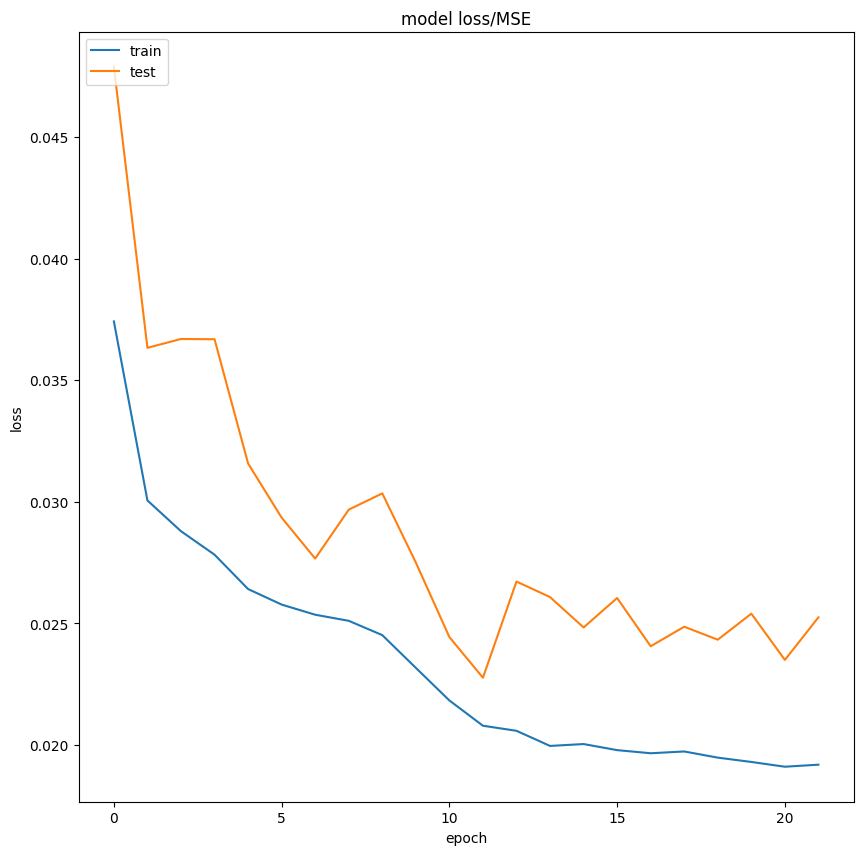

In [19]:
"""Change to a 10 day input sequence"""
seq_length = 10 * 24
ph = 24
feat_cols = ["PT08.S5(O3)"]

seq_arrays = (
    np.array([training_data[i:i + seq_length] for i in range(len(training_data) - seq_length - ph)], dtype = object)
    .astype(np.float32)
)
seq_labs = (
    np.array([training_data.iloc[i + ph] for i in range(seq_length, len(training_data) - ph)], dtype = object)
    .astype(np.float32)
    .ravel()
)

assert(seq_arrays.shape == (len(training_data) - seq_length - ph, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(training_data) - seq_length - ph,))

seq_arrays.shape

"""Run model with tuned hyperparameters"""
model_path = "LSTM_tuned.keras"

nb_features = 1
nb_out = 1

tuned_model = Sequential()
tuned_model.add(Input(shape=(seq_length, nb_features)))
tuned_model.add(LSTM(units=11, return_sequences=True))
tuned_model.add(LSTM(units=7,return_sequences=False))
tuned_model.add(Dropout(0.1))
tuned_model.add(Dense(units=nb_out))
tuned_model.add(Activation(keras.activations.sigmoid))

optimizer = keras.optimizers.Adam(learning_rate = .005)
tuned_model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mse"])
print(tuned_model.summary())

history = tuned_model.fit(
    seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=0, mode="min")]
            #    keras.callbacks.ModelCheckpoint(model_path, monitor="val_loss", save_best_only=True, mode="min", verbose=0)]
    )
print(history.history.keys())

loss_figure = plot_loss(history)

58/58 - 1s - 11ms/step - loss: 0.0271 - mse: 0.0271
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


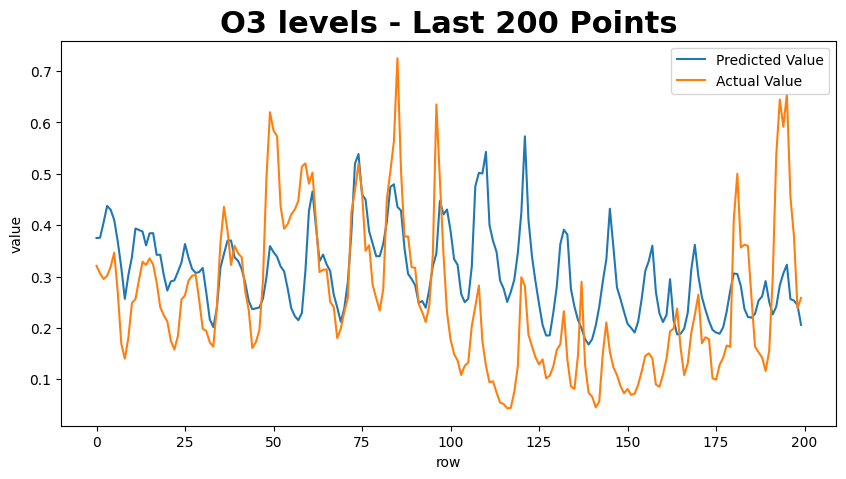


MSE: 0.027120398357510567


In [20]:
"""Create our validation sequence with a minimum number of records left padded with zeros"""
MIN_COUNT = 2

val_arrays = (
    np.array(pad_sequences([
    	validation_data[max(0, i): i + seq_length].values
    	for i in range(MIN_COUNT - seq_length, len(validation_data) - seq_length - ph)
		], dtype="float32"))
    .astype(np.float32)
)
val_labs = (
    np.array(
        [validation_data.iloc[i + ph] for i in range(MIN_COUNT, len(validation_data) - ph)])
    .astype(np.float32)
    .ravel()
)

assert(val_arrays.shape == (len(validation_data) - ph - MIN_COUNT, seq_length, len(feat_cols)))
assert(val_labs.shape == (len(validation_data) - ph - MIN_COUNT,))

"""Score our tuned model and visualize it's predictions"""
scores_test = tuned_model.evaluate(val_arrays, val_labs, verbose=2)
predictions = tuned_model.predict(val_arrays)

predictions_figure = plot_predictions(predictions, val_labs)
print("\nMSE: {}".format(scores_test[1]))

Better than the baseline but still not as good as using regression.  I'll probably opt to use regression for the prediction part of this assignment.

# Auto Encoder

In [ ]:
"""Train AE on Ground Truth data from certified sensor"""
split_point = (len(benzene) * 80)  // 100
training_data = benzene["C6H6(GT)"][:split_point]
testing_data = benzene["C6H6(GT)"][split_point:]

assert len(training_data) + len(testing_data) == len(benzene)

min_val = min(training_data)
max_val = max(training_data)

training_data = (training_data - min_val) / (max_val - min_val)
testing_data = (testing_data - min_val) / (max_val - min_val)

training_data = training_data.astype(np.float32)
testing_data = testing_data.astype(np.float32)

seq_length = 7 * 24

sequenced_training = (
    np.array([training_data[i:i + seq_length] for i in range(len(training_data) - seq_length)], dtype=object)
    .astype(np.float32)
)
sequenced_testing = (
    np.array([testing_data[i:i + seq_length] for i in range(len(testing_data) - seq_length)], dtype=object)
    .astype(np.float32)
)

assert(sequenced_training.shape == (len(training_data) - seq_length, seq_length))
assert(sequenced_testing.shape == (len(testing_data) - seq_length, seq_length))

sequenced_training.shape

(7317, 168)

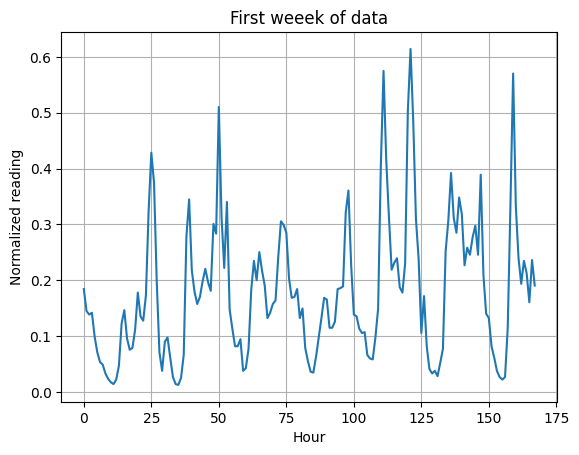

In [5]:
"""Plot reading for first week of hourly data"""
plt.title("First weeek of data")
plt.ylabel("Normalized reading")
plt.xlabel("Hour")
plt.grid()
plt.plot(np.arange(168), sequenced_training[0])
plt.show()

From the single week of data, it becomes apparent that there are several spike each day, likely corresponding to moring and afternoon commuter traffic.  Viewing it this way makes it quite apparent where the weekend falls on this graph

In [6]:
"""Build out and train auto encoder"""
class AnomalyDetector(keras.Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    
    self.encoder = Sequential([
      Dense(42, activation="relu"),
      Dense(21, activation="relu"),
      Dense(8, activation="relu")])

    self.decoder = Sequential([
      Dense(21, activation="relu"),
      Dense(42, activation="relu"),
      Dense(168, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(sequenced_training, sequenced_training,
          epochs=20,
          batch_size=512,
          validation_data=(sequenced_testing, sequenced_testing),
          shuffle=True)

Epoch 1/20


2026-02-05 13:43:40.493413: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3353 - val_loss: 0.3716
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3190 - val_loss: 0.3381
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2347 - val_loss: 0.1883
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1262 - val_loss: 0.0982
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1161 - val_loss: 0.1208
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1090 - val_loss: 0.1163
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1073 - val_loss: 0.1137
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1068 - val_loss: 0.1147
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1063 - val_loss: 0.1129
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1058 - val_loss: 0.1100
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1051 - val_loss: 0.1111
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1043 - val_loss: 0.1075

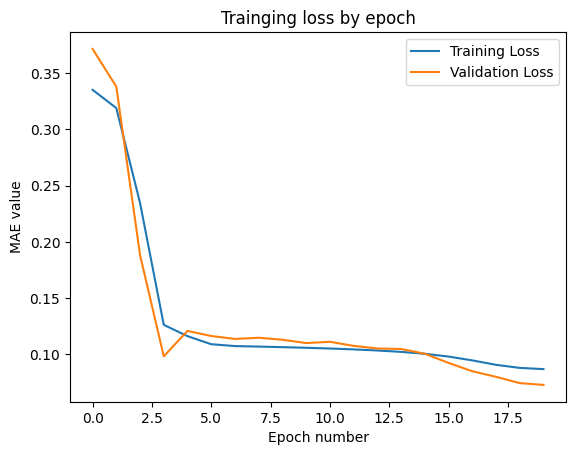

In [7]:
"""Visualize training loss"""
plt.title("Trainging loss by epoch")
plt.ylabel("MAE value")
plt.xlabel("Epoch number")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

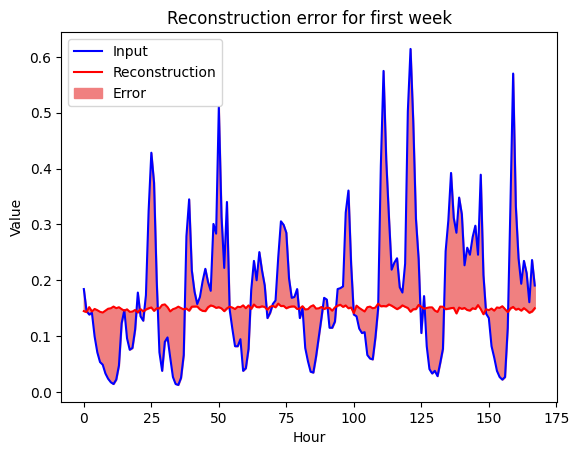

In [8]:
"""Visualize reconstruction error for first week of data"""
encoded_data = autoencoder.encoder(sequenced_training).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.title("Reconstruction error for first week")
plt.ylabel("Value")
plt.xlabel("Hour")
plt.plot(sequenced_training[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(168), decoded_data[0], sequenced_training[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [9]:
"""Determine threshold for considering something an anomoly"""
reconstructions = autoencoder.predict(sequenced_training)
training_loss = keras.losses.mean_absolute_error(reconstructions, sequenced_training)

threshold = np.mean(training_loss) + np.std(training_loss)
print("Threshold: ", threshold)

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
Threshold:  0.11068015


In [10]:
def predict_drift(model, data, threshold):
	reconstructions = model(data)
	loss = keras.losses.mean_absolute_error(reconstructions, data)
	return ~tf.math.less(loss, threshold)

preds = predict_drift(autoencoder, sequenced_testing, threshold)
anomoly_count = tf.reduce_sum(tf.cast(preds, tf.int32))

anomoly_count.numpy().item()

0

As expected, no anomalies in our ground truth data.